# Anomaly Detection

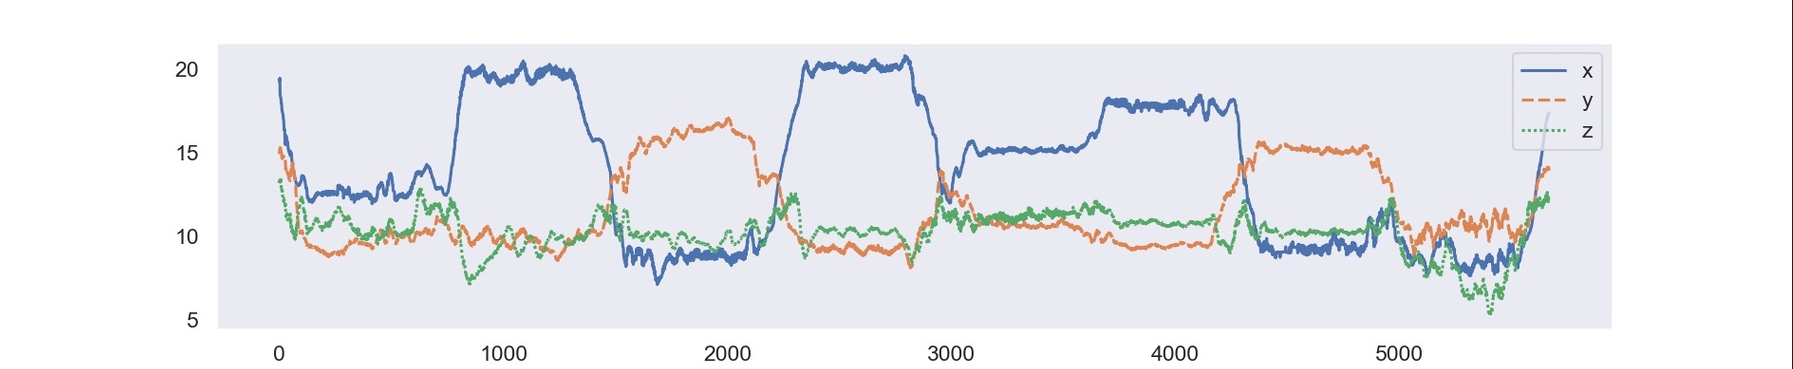

## About the dataset

* This data set was used during a thesis to develop safer smart environments. The origin is a care independent smart home environment to detect the falling of elderly people.

* As many time series classification tasks are prone to low dimension this data set contains three dimensional parameters. X, Y and Z represent sensor positions at each sample. The timestamps of each measurement were eradicated, as timestamps as feature tend to be principal components for classification tasks. The problem within the use of timestamps is an unbalanced learning task without a broad generalization possibility.

* 010-000-024-033, 010-000-030-096, 020-000-032-221 and 020-000-033-111 are one-hot encoded representations of each sensor activity. Four sensors were used during the experiments, which have been fixed to the persons chest, ankles and belt.

* The labels represent the falling/normal-living event, where 0 is normal and 1 is the anomalous event of falling.

* Each .csv file is a distinct person which has been observed during the experiments. 5 test persons are given and 20 training persons.

[More details here](https://www.kaggle.com/datasets/jorekai/anomaly-detection-falling-people-events)

## Install packages for analysis

In [1]:
#r "nuget:Microsoft.ML"
#r "nuget:Microsoft.Data.Analysis"
#r "nuget:XPlot.Plotly,3.0.1"

Installed Packages Microsoft.Data.Analysis, 0.20.1 Microsoft.ML, 2.0.1 XPlot.Plotly, 3.0.1

Loading extensions from `C:\Users\marcu\.nuget\packages\microsoft.data.analysis\0.20.1\interactive-extensions\dotnet\Microsoft.Data.Analysis.Interactive.dll`

## Import namespaces for analysis

* **System**:                    Provides fundamental types and core functionality of the .NET.
* **System.Linq**:               Provides querying capabilities to work with collections and arrays.
* **System.IO**:                 Provides types for working with files and directories.
* **System.Reflection**:         Provides classes that enable you to obtain information about loaded assemblies and types.
* **Microsoft.ML**:              Provides the main MLContext class for working with ML.NET.
* **Microsoft.ML.Data**:         Provides types for working with data in ML.NET.
* **Microsoft.ML.Trainers**:     Provides trainers for ML.NET models.
* **Microsoft.Data.Analysis**:   Provides classes for data analysis and manipulation.
* **XPlot.Plotly**:              Provides interactive and high-quality plotting functionality using Plotly.

In [2]:
using System;
using System.Linq;
using System.IO;
using System.Reflection;
using Microsoft.ML;
using Microsoft.ML.Data;
using Microsoft.ML.Trainers;
using Microsoft.Data.Analysis;
using XPlot.Plotly;

## Create model input class

In [3]:
/// <summary>
/// Represents the input data for the model.
/// </summary>
private sealed class ModelInput
{
    [LoadColumn(0)]
    public float Xposition            { get; set; }
    [LoadColumn(1)]
    public float Yposition            { get; set; }
    [LoadColumn(2)]
    public float Zposition            { get; set; }
    [LoadColumn(3)]
    public float FirstSensorActivity  { get; set; }
    [LoadColumn(4)]
    public float SecondSensorActivity { get; set; }
    [LoadColumn(5)]
    public float ThirdSensorActivity  { get; set; }
    [LoadColumn(6)]
    public float FourthSensorActivity { get; set; }
    [LoadColumn(7)]
    public float Anomaly              { get; set; }
}

## Create model output class

In [4]:
/// <summary>
/// Represents the output data from the model.
/// </summary>
private sealed class ModelOuput
{
    public bool  PredictedLabel { get; set; }
    public float Score          { get; set; }
}

## Create Scatter Metrics class

In [5]:
/// <summary>
/// Represents scatter metrics for evaluating classification models.
/// </summary>
private sealed class ScatterMetrics
{
    public List<double> FalsePositiveRate { get; set; } = new List<double>();
    public List<double> TruePositiveRate  { get; set; } = new List<double>(); 
}

## Initialize main variables

In [6]:
// Initialize MLContext with a seed value
MLContext ml             = new MLContext(seed: 1);

// Set the base files path
string    baseFilesPath  = Path.Combine(Directory.GetCurrentDirectory(), "data");

// Define the path for training files
string    trainFilesPath = Path.Combine(baseFilesPath, "train", "*");

// Define the path for testing files
string    testFilesPath  = Path.Combine(baseFilesPath, "test", "*");

## Create method for load csv files

In [7]:
/// <summary>
/// Loads CSV files from the specified path and returns an IDataView.
/// </summary>
/// <param name="ml">The MLContext object used for loading the data.</param>
/// <param name="filesPaths">The path to the CSV file(s) to be loaded.</param>
/// <returns>An IDataView object containing the loaded data.</returns>
private IDataView LoadCSVFilesByPath(MLContext ml, string filesPaths)
{
    // Load the CSV file(s) into an IDataView object using the specified MLContext.
    IDataView dataView = ml.Data.LoadFromTextFile<ModelInput>(filesPaths, 
                                                              hasHeader: true, 
                                                              separatorChar: ',');
    return dataView;                                                             
}

## Create method for extract all features in model

In [8]:
/// <summary>
/// Extracts the names of the features in the ModelInput class and returns them as an array of strings.
/// </summary>
/// <returns>An array of strings containing the names of the features in the ModelInput class.</returns>
private string[] ExtractModelInputFeaturesNames()
{
    // Get all public instance properties of the ModelInput class and extract their names.
    string[] featuresNames = typeof(ModelInput)
                                .GetProperties(BindingFlags.Instance | BindingFlags.Public)
                                .Select(p => p.Name)
                                .ToArray();

    return featuresNames;
}

## Create method for define model pipeline

In [9]:
/// <summary>
/// Creates a model pipeline using MLContext and returns an EstimatorChain object.
/// </summary>
/// <param name="ml">The MLContext object used for creating the model pipeline.</param>
/// <returns>An EstimatorChain object representing the model pipeline.</returns>
private EstimatorChain<AnomalyPredictionTransformer<PcaModelParameters>> CreateModelPipeline(MLContext ml)
{
    // Set the options for the RandomizedPcaTrainer.
    RandomizedPcaTrainer.Options options = new RandomizedPcaTrainer.Options()
    {
        Rank = 4
    };

    // Extract the feature names from the ModelInput class.
    string[] featuresNames = ExtractModelInputFeaturesNames();
    
    // Create the model pipeline by concatenating the features and appending the RandomizedPca trainer.
    EstimatorChain<AnomalyPredictionTransformer<PcaModelParameters>> pipeline = ml.Transforms.Concatenate("Features", featuresNames)
                                                                                             .Append(ml.AnomalyDetection.Trainers.RandomizedPca(options));

    return pipeline;
}

## Load train Data

In [10]:
// Load the training CSV file(s) into an IDataView object.
IDataView trainDataView = LoadCSVFilesByPath(ml, trainFilesPath);
trainDataView.ToDataFrame().Head(5)

index,Xposition,Yposition,Zposition,FirstSensorActivity,SecondSensorActivity,ThirdSensorActivity,FourthSensorActivity,Anomaly
0,18.49586,13.766527,14.362624,0,0,0,1,0
1,18.501072,13.827225,14.2702675,0,0,1,0,0
2,18.40595,13.868976,14.094804,1,0,0,0,0
3,18.444572,13.910701,14.116078,0,1,0,0,0
4,18.41847,13.933917,14.320566,0,0,0,1,0


## Load Test Data

In [11]:
// Load the testing CSV file(s) into an IDataView object.
IDataView testDataView = LoadCSVFilesByPath(ml, testFilesPath);
testDataView.ToDataFrame().Head(5)

index,Xposition,Yposition,Zposition,FirstSensorActivity,SecondSensorActivity,ThirdSensorActivity,FourthSensorActivity,Anomaly
0,6.9129972,11.518698,15.471855,0,0,0,1,0
1,6.936432,11.574586,15.446939,0,0,1,0,0
2,6.935274,11.57179,15.437505,1,0,0,0,0
3,6.8866878,11.561593,15.704019,0,0,0,1,0
4,6.921823,11.597729,15.634436,0,0,1,0,0


## Create method for train model

In [12]:
/// <summary>
/// Trains a model using the provided MLContext and returns the trained ITransformer.
/// </summary>
/// <param name="ml">The MLContext object used for training the model.</param>
/// <returns>The trained ITransformer object.</returns>
private ITransformer TrainModel(MLContext ml)
{
    // Create the model pipeline.
    EstimatorChain<AnomalyPredictionTransformer<PcaModelParameters>> pipeline = CreateModelPipeline(ml);
    
    // Fit the pipeline to the training data.
    ITransformer model = pipeline.Fit(trainDataView);
    return model;
}

ITransformer model = TrainModel(ml);

## Create method for predict using test data

In [13]:
/// <summary>
/// Generates predictions using the provided testDataView and returns a list of ModelOutput objects.
/// </summary>
/// <param name="testDataView">The IDataView containing the test data.</param>
/// <returns>A list of ModelOutput objects representing the prediction results.</returns>
private List<ModelOuput> PredictResults(MLContext ml, IDataView testDataView)
{
    // Transform the test data using the trained model.
    IDataView        predictions = model.Transform(testDataView);

    // Create a list of ModelOutput objects from the transformed predictions.
    List<ModelOuput> results     = ml.Data.CreateEnumerable<ModelOuput>(predictions, reuseRowObject: false).ToList();

    return results;
}

List<ModelOuput> results = PredictResults(ml, testDataView);

## Create method to show number of falls

In [14]:
/// <summary>
/// Displays the number of falls detected among the provided list of ModelOutput results.
/// </summary>
/// <param name="results">The list of ModelOutput results.</param>
private void ShowNumberOfFallsDetected(List<ModelOuput> results)
{
    int numberOfFallsDetected = 0;

    foreach (ModelOuput result in results.Where(result => result.PredictedLabel))
    {
        numberOfFallsDetected += 1;
    }

    Console.WriteLine($"Number of Falls detected: {numberOfFallsDetected}, Where the total number of measurements is: {results.Count}.");
}

// Show the number of falls detected in the provided list of results
ShowNumberOfFallsDetected(results);

Number of Falls detected: 978, Where the total number of measurements is: 30030.


## Create method for generate thresholds

In [15]:
/// <summary>
/// Generates a sequence of thresholds from 0.0 to 1.0 with a step size of 0.01.
/// </summary>
/// <returns>An IEnumerable of double values representing the generated thresholds.</returns>
private IEnumerable<double> GenerateThresholds()
{
    for (double thresh = 0.0; thresh <= 1.0; thresh += 0.01)
    {
        yield return thresh;
    }
}

## Define variables to measure model precision

In [16]:
// Get the "Anomaly" column values from the testDataView and convert them to an array of float.
float[] yTest = testDataView.GetColumn<float>("Anomaly").ToArray();

// Get the "Score" values from the results and convert them to an array of float.
float[] yPred = results.Select(x => x.Score).ToArray();

## Create method for generate scatter metrics

In [17]:
/// <summary>
/// Generates scatter metrics using the provided ground truth labels and predicted scores.
/// </summary>
/// <param name="yTest">The array of ground truth labels.</param>
/// <param name="yPred">The array of predicted scores.</param>
/// <returns>A ScatterMetrics object containing the computed scatter metrics.</returns>
private ScatterMetrics GenerateScatterMetrics(float[] yTest, float[] yPred)
{
    // Create a ScatterMetrics object to store the computed scatter metrics.
    ScatterMetrics       scatterMetrics    = new ScatterMetrics();

    // Generate the sequence of thresholds.
    IEnumerable<double>  thresholds        = GenerateThresholds();
    
    // Calculate the total number of positive and negative instances in yTest.
    float                totalOfPositives  = yTest.Sum(v => v);
    float                totalOfNegatives  = yTest.Count() - totalOfPositives;

    // Iterate through all thresholds and determine fraction of true positives
    // and false positives found at this threshold
    foreach (double thresh in thresholds)
    {
        int falsePositives = 0;
        int truePositives  = 0;
    
        foreach (int index in Enumerable.Range(0, yPred.Length))
        {
            if (yPred[index] <= thresh)
            {
                continue;
            }
        
            if (yTest[index] == 1.0)
            {
                truePositives++;
            }
            else if (yTest[index] == 0.0)
            {
                falsePositives++;            
            }
        }
    
        // Compute and add the false positive rate and true positive rate to the scatter metrics.
        scatterMetrics.FalsePositiveRate.Add((double)falsePositives / totalOfNegatives);
        scatterMetrics.TruePositiveRate.Add((double)truePositives / totalOfPositives);
    }

    return scatterMetrics;
}

// Generate scatter metrics using the ground truth labels (yTest) and predicted scores (yPred).
ScatterMetrics scatterMetrics = GenerateScatterMetrics(yTest, yPred);

## Create method for calculate AUC

In [18]:
/// <summary>
/// Calculates the Area Under the Curve (AUC) using the provided scatter metrics.
/// </summary>
/// <param name="scatterMetrics">The ScatterMetrics object containing the scatter metrics.</param>
/// <returns>The computed AUC value.</returns>
private double CalculateAUC(ScatterMetrics scatterMetrics)
{
    // Sort the points by ascending order of false positive rate
    List<(double fpr, double tpr)> points = new List<(double fpr, double tpr)>();
    
    foreach (int index in Enumerable.Range(0, scatterMetrics.FalsePositiveRate.Count))
    {
        points.Add((scatterMetrics.FalsePositiveRate[index], scatterMetrics.TruePositiveRate[index]));
    }
    
    points.Sort();

    double auc     = 0.0;
    double prevFPR = 0.0;
    double prevTPR = 0.0;

    // Apply the trapezoidal rule to approximate the integral
    foreach ((double fpr, double tpr) point in points)
    {
        double currFPR = point.fpr;
        double currTPR = point.tpr;

        double width   = currFPR - prevFPR;
        double height  = (prevTPR + currTPR) / 2.0;

        auc += width * height;

        prevFPR = currFPR;
        prevTPR = currTPR;
    }

    return auc;
}

double areaUnderRocCurve = CalculateAUC(scatterMetrics);
Console.WriteLine($"AUC Curve: {areaUnderRocCurve}");

AUC Curve: 0,7377688925216692


## Create method for generate Linear Regression Scatter

In [19]:
/// <summary>
/// Generates a Scatter object representing a linear regression line for a graph.
/// </summary>
/// <returns>A Graph.Scatter object representing the linear regression line.</returns>
private Graph.Scatter GenerateLinearRegressionScatter()
{
    Graph.Scatter linearRegressionScatter  = new Graph.Scatter()
    {
        x      = new[] { 0.0, 1.0 },
        y      = new[] { 0.0, 1.0 },
        name   = "",
        mode   = "lines",    
        line   = new Graph.Line { dash = "dash", color = "orange" }
    };
    
    return linearRegressionScatter;
}

## Create method for generate AUC Scatter

In [20]:
/// <summary>
/// Generates a Scatter object representing the AUC (Area Under the Curve) scatter plot.
/// </summary>
/// <param name="scatterMetrics">The ScatterMetrics object containing the scatter metrics.</param>
/// <returns>A Graph.Scatter object representing the AUC scatter plot.</returns>
private Graph.Scatter GenerateAucScatter(ScatterMetrics scatterMetrics)
{
    Graph.Scatter aucScatter = new Graph.Scatter
    {
        x      = scatterMetrics.FalsePositiveRate,
        y      = scatterMetrics.TruePositiveRate,
        name   = "",
        mode   = "lines",
        line   = new Graph.Line { dash = "dash", color = "navy" },
        fill   = "tozeroy"
    };

    return aucScatter;
}

## Create method to plot AUC Curve

In [21]:
/// <summary>
/// Plots the AUC (Area Under the Curve) curve using the provided scatter metrics and area under the ROC curve value.
/// </summary>
/// <param name="scatterMetrics">The ScatterMetrics object containing the scatter metrics.</param>
/// <param name="areaUnderRocCurve">The area under the ROC curve value.</param>
private void PlotAucCurve(ScatterMetrics scatterMetrics, double areaUnderRocCurve)
{
    // Generate the AUC scatter plot and linear regression scatter plot
    Graph.Scatter aucScatter              = GenerateAucScatter(scatterMetrics);
    Graph.Scatter linearRegressionScatter = GenerateLinearRegressionScatter();

    // Create a Plotly chart and add the scatter plots
    PlotlyChart   chart                   = Chart.Plot(new[] { aucScatter, linearRegressionScatter });

    // Configure the chart layout
    chart.WithLayout(new Layout.Layout()
    {            
        plot_bgcolor  = "white",
        paper_bgcolor = "white",
        showlegend    = false,
        title         = $"ROC Curve of Randomized PCA, AUC={areaUnderRocCurve:0.##}",
        titlefont = new Graph.Font
        {                
            size  = 30,
            color = "black"
        },
        xaxis = new Graph.Xaxis
        {
            title = "False Positive Rate (1 - Specificity)"
        },
        yaxis = new Graph.Yaxis
        {
            title = "True Positive Rate (Sensitivity)"
        }
    });

    // Display the chart
    chart.Show();
}

// Plot the AUC curve using the scatter metrics and area under the ROC curve value
PlotAucCurve(scatterMetrics, areaUnderRocCurve)

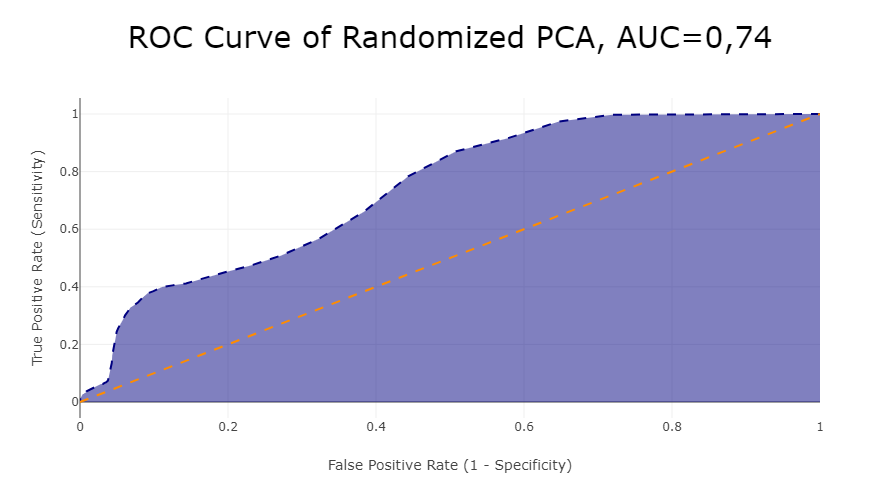